# 03 - SGD Optimiser

In this section, we set up a Deep Neural Network (DNN) with standard SGD as the chosen optimiser function. The initial aim was to group all optimisers in one notebook, but this causes memory issues due to too many large variables and tensors being assigned to the GPU's memory. Instead, we run each of these independently and save our models/histories for comparison later on.

## Import

In [2]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

## Load Data

We load the data created in the 01 - Data Setup section of this report.

In [3]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

Now we perform the processing for our categorical y's

In [4]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

Preview of what our categorical data looks like

In [23]:
np.unique(y_test_multi,axis=0)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Training

Below we define two functions that create a binary and a categorical Deep Neural Net and we then briefly discuss some of the choices made.

In [5]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

 

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', 
             c_metrics = ['accuracy',TruePositives(),tfa.metrics.CohenKappa(num_classes=5)]):
    
    '''
    Function that takes dataframe train_df and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    train_df = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final 
                   output layer containing num_classes softmax nodes
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    c_metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    #we initiate our model differently here, taking layers as a list
    #this is because of some issues when implementing when creating a neural net as above
    layers = []
    #input dimensions
    layers.append(Input(shape = (train_df.shape[1],)))
    
    #add layers with dropout
    for i in hidden_nodes:
        layers.append(Dense(i, activation = 'relu'))
        layers.append(Dropout(0.2))
        
    #output layer with number of nodes = num_classes
    layers.append(Dense(num_classes, activation = 'softmax'))
    
    nn_model = Sequential(layers)
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=c_metrics)
    
    return nn_model

Further, since we will be assessing how our optimizers work on different learning rates for more meaningful comparison, we create an array of epsilons below.

In [5]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [6]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Now to discuss the architectural decisions made in some detail.

The code below was created to iterate over each value of epsilon created above, creating a binary and multiclass DNN for each of our optimizers using the functions `binaryDNN()` and `multiDNN()` that we defined earlier. However, as mentioned in the beginning of this notebook, this caused a memory issue as too many large variables were being stored, so some of the sections are commented out / not optimal. But the code runs perfectly fine and in a reasonable amount of time (approximately 15 minutes to run on my GPU, and should take anywhere from 7-8 minutes on an HPC). 

The parameters we choose for the neural network are as follows:
- **hidden layers:** 3 layers, 10 nodes each.
    - 1 output layer (sigmoid) for binary, 
    - 5 output layers (softmax) for multiclass
        - There are some issues with softmax, namely if classes in the train and test datasets are different. However, we constructed our dataset in such a manner that this issue should not take place. 
- **epochs:** 30
    - this is the number of times our model parses through the data fully to keep updating its parameters, making this number too high can cause overfitting, so we use just enough to enable decent comparison and convergence behaviour of optimizers and learning rates
    - ideally, we would choose a higher number of epochs and then use some method to determine an early stopping for the number of epochs (either manually by plotting loss function or using an off-the-shelf method), though there is some difficulty that comes with this for our given dataset so we do not do this. This will be discussed briefly later. 
- **batch size:** 500
    - the number of data points that the model goes through in a single go before calculating the direction of the next step along the gradient. 
    - when this number is large, more data points are taking into account when updating each step and so for a large number, the model takes less time to run (there are less batches to calculate), but:
        - the model may generalise badly as it overfits or moves to sharper minima. 
            -  *It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize... The lack of generalization ability is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function.The lack of generalization ability is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function.* ~  [Keskar et al. 2017](https://arxiv.org/abs/1609.04836)[1]
        - indeed, our batch size is somewhat on the larger end (the paper mentions that empirically 32-512 works well), but it improves computational speed so we keep it for now. 
    - we would have liked to work with various different batch sizes and assess performance, but if we did this with everything, we would have too many parameters and models to juggle. Further, it is arguably best to leave batch size to 32 (the de facto default) as this is one less parameter to tune and may lead to better generalisation ability. However, this is significantly slower and so we keep with 500 for now to favour speed.
- **losses:** 
    - binary crossentropy (binary model) 
    - categorical crossentropy (categorical model); self explanatory
- **metrics:** 
    - AUC for binary; self explanatory, works better than standard accuracy
    - Categorical Accuracy, True Positives, and Cohen-Kappa for categorical (to allow for more comparison)
        - Accuracy is almost a natural choice but it is lacking for imbalanced datasets (which ours is)
        - True Positives was put initially but given the large imbalance again, meaningful comparison became difficult. One usage could be to use a custom metric that measures true positives on the smaller classes only, but we do not attempt this here.
        - Cohen Kappa to measure how two raters (the truth and prediction in our case) agree with one another, taking into account chance agreements. 
        - note that these metrics do not affect the model; the model works only to minimise the loss function, these are just measures to allow for interpretability and comparison- note that these metrics do not affect the model; the model works only to minimise the loss function, these are just measures to allow for interpretability and comparison
    - finding good metrics that weren't custom-made for our largely imbalanced dataset was hard to do and so we recognise that these are not ideal metrics but they should help with interpretabilty nonetheless.

            
*Note: the variable v = 0 below is used to toggle the `verbose` argument for the neural networks. Keep this at 0 if you do not want to see the performance of the model at each epoch shown, and 1 if you do want to see this.* 

In [24]:
#Jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

#verbose variable
v = 0

count = 1
#number of times our model parses through the entire data it is given
epochs = 30
#number of data points the model goes through before updating next weight
batch_size = 500
start = time.time()

for eps in epsilons:
    #assign optimiser. Some are commented out and then used in other notebooks
    sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      nesterov = False)

    # nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
    #                                   momentum = 0.9, 
    #                                   nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #this originally fit same model architecture for each optimizer ['sgd','nag','adam']
    #the list iteration format was kept because iterating over 1 variable does change runtime, realistically
    #we also wanted to demonstrate the code style were we to not face memory issues
    for opt in ['sgd']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #nicer preview/output readability
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #record model history fitting to binary training data with validation split
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = v)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        #nice print
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #fit model
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = v)
        #assign model and history to variables
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
    #delete temp model and history to free up memory
    del bin_model_temp
    del bin_history_temp
    del categ_model_temp
    del categ_history_temp
    print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd optimizer with learning rate 0.1----------
----------Fitting categorical model to sgd optimizer with learning rate 0.1----------

----------Fitting binary model to sgd optimizer with learning rate 0.01----------
----------Fitting categorical model to sgd optimizer with learning rate 0.01----------

----------Fitting binary model to sgd optimizer with learning rate 0.001----------
----------Fitting categorical model to sgd optimizer with learning rate 0.001----------

----------Fitting binary model to sgd optimizer with learning rate 0.0001----------
----------Fitting categorical model to sgd optimizer with learning rate 0.0001----------



### Save Models and Histories

We save the models and the histories created so that they can be reloaded easily if we need to do further analysis or revisit anything at a later point without running all the models again. 

Run these anyway even if you do not intend to stop and return to them, as this affects how the model histories are called later.

In [27]:
#create a folder called saved_models and one called saved_hists to prevent saving errors
!mkdir saved_models saved_hists

#since epsilons[0] corresponds to model_1 and epsilons[3] correponds to model_4 we use range(1, len(epsilons) + 1)
for i in range(1,len(epsilons)+1):
    
    #assign name to variable for better code readability later
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    #save the binary and category models in saved_models folder
    locals()[bin_name].save('saved_models/{}'.format(bin_name))
    locals()[categ_name].save('saved_models/{}'.format(categ_name))

    #as above, for histories
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    #call .history and dump using json
    json.dump(locals()[bin_hist].history, open('saved_hists/{}'.format(bin_hist), 'w'))
    json.dump(locals()[categ_hist].history, open('saved_hists/{}'.format(categ_hist), 'w'))    

A subdirectory or file saved_models already exists.
Error occurred while processing: saved_models.
A subdirectory or file saved_hists already exists.
Error occurred while processing: saved_hists.


INFO:tensorflow:Assets written to: saved_models/sgd_bin_model_1\assets
INFO:tensorflow:Assets written to: saved_models/sgd_categ_model_1\assets
INFO:tensorflow:Assets written to: saved_models/sgd_bin_model_2\assets
INFO:tensorflow:Assets written to: saved_models/sgd_categ_model_2\assets
INFO:tensorflow:Assets written to: saved_models/sgd_bin_model_3\assets
INFO:tensorflow:Assets written to: saved_models/sgd_categ_model_3\assets
INFO:tensorflow:Assets written to: saved_models/sgd_bin_model_4\assets
INFO:tensorflow:Assets written to: saved_models/sgd_categ_model_4\assets


## Load Models and Histories

Now to load the data that we just saved.

In [5]:
#change this opt varfor each optimiser later
opt = 'sgd'
#reassign same epsilons in case you do not want to run from above
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

#load as with the saving above
for i in range(1,len(epsilons)+1):
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    
    locals()[bin_name] = tf.keras.models.load_model('saved_models/{}'.format(bin_name))
    locals()[categ_name] = tf.keras.models.load_model('saved_models/{}'.format(categ_name))
    
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))

## Plots and Assessing Performance

Below, we plot the performance for our SGD optimizer with no momentum. This is the performance on our out-of-sample validation set, since we care about this more than if our model can perform well by overfitting on the training set.

Note that we are plotting for the **validation** only and not the training, as we mostly care about the out-of-sample performance. If our models were performing badly, then we could plot training against validation learning curves to diagnose for bias and/or variance. But we do not explore that much here.

### Binary Model

**Binary Cross Entropy Loss:**<br>
First we look at how binary crossentropy loss decreases. This should give us a clearer idea of how our model choice converges to some optimum. However, the true meaning behind the loss can be difficult to interpret and it's difficult to tell through this alone whether the convergence takes place at a desirable minimum or not.

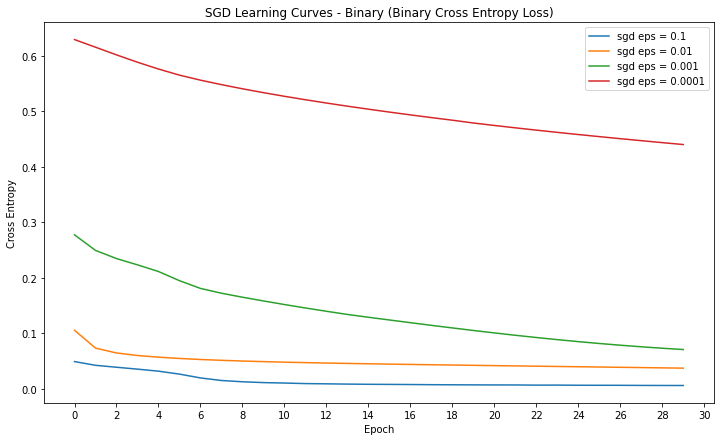

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

There is a clear picture here: the higher learning rates offered faster convergence to some minimum (with respect to the loss function) over the number of epochs that we ran our model. This does not necessarily mean that high values of learning rate (e.g. 1 or 10) would be good necessarily, just that extremely low values are not particularly optimal in this case. Also, note, that these optimisers need not be converging to the *same* minima just because they are converging to similar loss scores.

**AUC:**<br>
To make more sense out of loss plot above, we look at how the model performed through an AUC score metric.

In [31]:
#sometimes the val_auc would get renamed to val_auc_1 so this is to prevent errors below
auc = list(sgd_bin_history_1.keys())[-1]
auc

'val_auc'

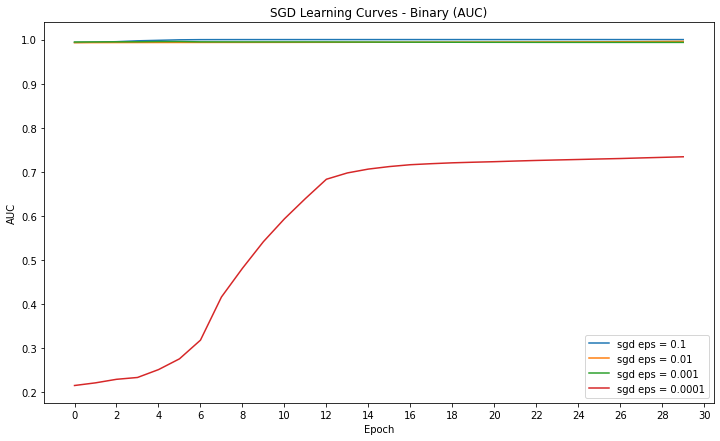

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

A similar behaviour to what we had for our loss plots is seen; the lowest learning rate performs the worst and is the slowest to converge to a good solution (whether it fully converges or not, we cannot tell from this plot as we only ran for 30 epochs), whereas the higher 3 learning rates performed almost perfectly.

We inspect the plots again below, removing `eps = 0.0001`, so that we can see the other learning rates' performances much more clearly.

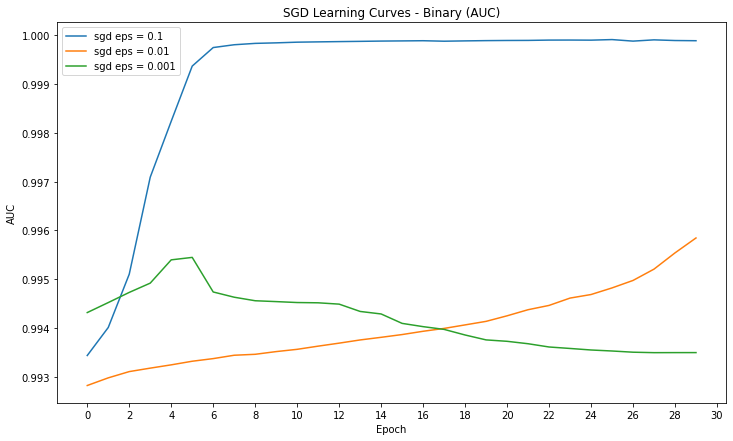

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Something interesting is happening here. It seems as though the learning rate of 0.01 is not performing better for the first 18 epochs (at least in terms of AUC), even though it was consistently at a lower binary crossentropy score. Though, interestingly, the curve for 0.001 learning rate seems to decrease after a while, possibly due to having overfit to the training data in comparison to the out-of-sample data we are assessing it on here. The most likely explanation is that the optimiser moves towards attacks wit more certainty (as they are more prevalent), thus decreasing in loss (as seen in the previous plot) but also assigns 'normal' less frequently overall, thus performing worse in terms of AUC.

We do see a clear outperformance by the learning rate of 0.1, though realistically, a difference between 1 and 0.993 may not really be that significant.

**Confusion Matrices**<br>
We take a look at the best performing binary model for completeness, but we will mostly focus on the categorical case later so we need not make many comments here.

In [47]:
#set random seed
tf.random.set_seed(rseed)
#predict results for X_test
sgd_pred = sgd_bin_model_1.predict(X_test)

In [48]:
sgd_pred_bin = sgd_pred
#assign prediction to 1 if 'probability' >= 0.5
sgd_pred_bin[sgd_pred_bin>=0.5]=1
#assign to 0 otherwise
sgd_pred_bin[sgd_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for SGD with learning rate 0.1')

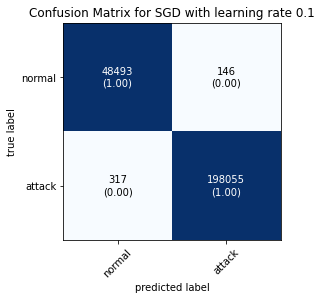

In [49]:
#initialise confusion matrix looking at test vs pred
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd

#plot matrix, normalising for categories
plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for SGD with learning rate {}'.format(epsilons[0]))

Practically perfect performance, nothing much to comment on here as this was an easier problem for our model. We look at model 3 (eps = 0.001) to see if our suspicion that it assigns fewer normals is correct.

In [50]:
#set random seed
tf.random.set_seed(rseed)
#predict results for X_test
sgd_pred = sgd_bin_model_3.predict(X_test)

In [51]:
sgd_pred_bin = sgd_pred
#assign prediction to 1 if 'probability' >= 0.5
sgd_pred_bin[sgd_pred_bin>=0.5]=1
#assign to 0 otherwise
sgd_pred_bin[sgd_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for SGD with learning rate 0.1')

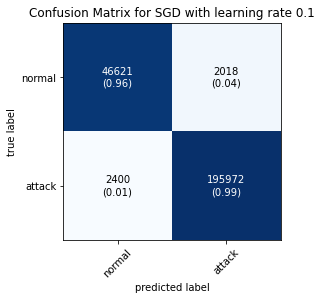

In [52]:
#initialise confusion matrix looking at test vs pred
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd

#plot matrix, normalising for categories
plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for SGD with learning rate {}'.format(epsilons[0]))

We seem to have been correct in our intuition, that the model starts to overfit to score better on the loss function but moves to a region where the actual predictions become worse. Though, surprisingly, here we are also predicting fewer attacks, where the expectation was that more connections would be assigned as attacks.

### Categorical Model

**Categorical Cross Entropy Loss**<br>
Similarly to what we did above, we look at the learning curves, plotting categorical crossentropy loss for our multiclass model.

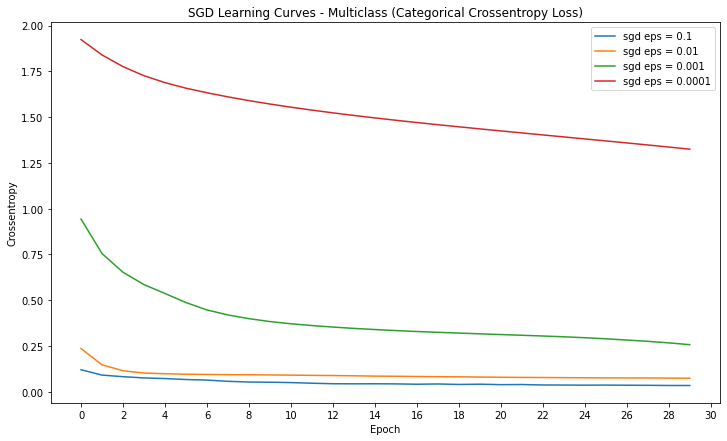

In [ ]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

This is realistically the same image as we saw above for the binary model but with higher loss values throughout, which is entirely expected given that the dataset is the same and so it is not unreasonable to suspect that different attack categories lie on some shared manifold that coincides with the binary attacks in a lower dimension. However, having more categories to distinguish from, especially when some of them are less prevalent in the training data is naturally a more difficult problem and so the higher loss values are also expected.

**Categorical Accuracy**<br>
Again, we look at another measure to gain better understanding of what is shown to us by the loss function above. Here, we look at categorical accuracy.

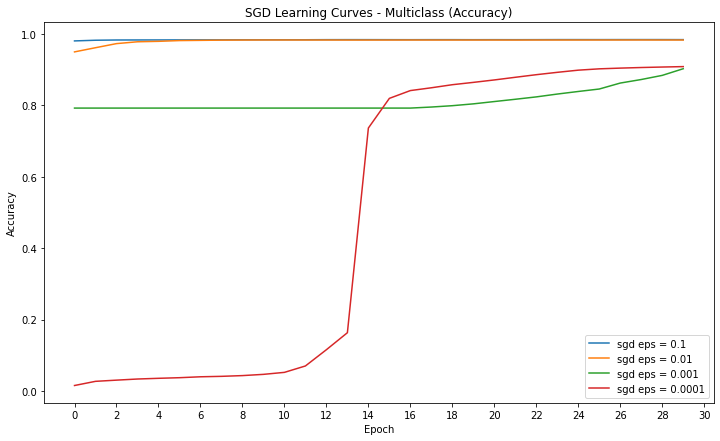

In [54]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Unsurprisingly, the same behaviour persists; very low values of learning rate seem to perform worse in classification. This time, however, we see that the learning rate of 0.001 seems to persist at a singular value (probably $\approx$0.79 as that is the fraction of 'dos' attacks in the dataset). It seems to be stuck in that local minimum for a while, and in fact performs worse than a learning rate of 0.0001 after 15 epochs. We attribute this again to staying in a minimum where class assignment isn't necessarily changing, but the certainty in predicting those classes correctly goes up, before escaping the local minimum and moving elsewhere on the function. What happens after 30 epochs would be interesting to look at, but these results changed after we altered some of the variables such as batch size quite last minute, so we did not have time to explore further epochs. 

We remove the lowest values and plot again to enable clearer comparison since the higher two values perform so closely to one another as well, just to confirm which does best for completeness.

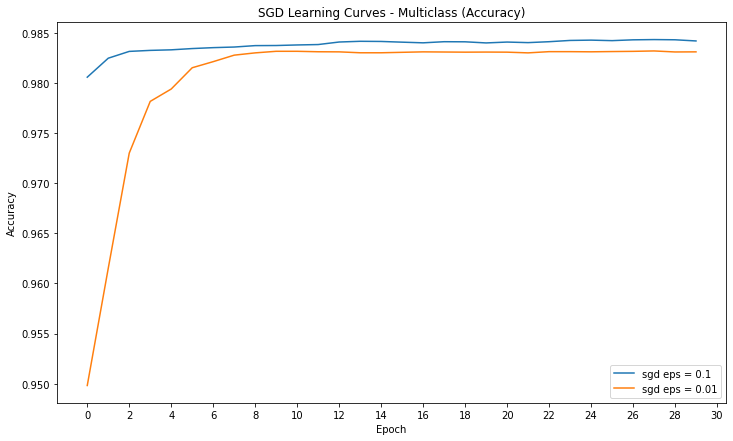

In [59]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

We can confirm once more that the learning rate of 0.1 seems to perform better for the multiclass case as it did for the binary case, but there is not too much to comment on here, regarding performance.

**Cohen-Kappa Score:**<br>
However, we know that the accuracy is a flawed metric, so we also look at Cohen-Kappan below.

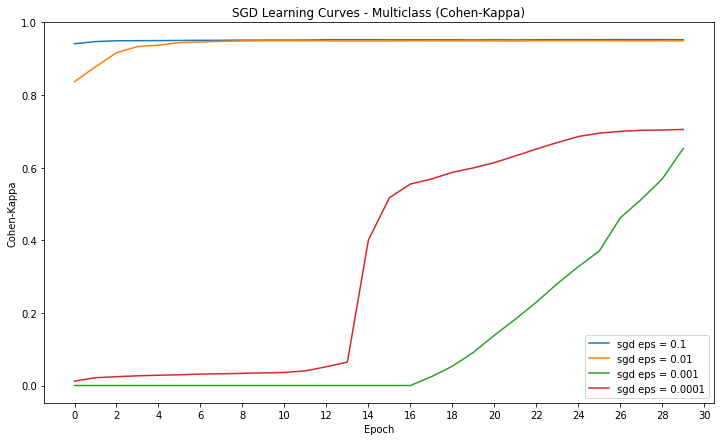

In [55]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Interestingly, the learning rate of 0.001 immediately scores lower here, probably because of how frequently it is assigning everything as a 'dos' connection. This would make sense as this would imply that the model is not acting as a similar 'rater' to the test labels, and is instead just rating everything as 'dos'. Because of this, and perhaps in a somewhat contradictory manner, the Cohen-Kappa score would imply that a learning rate of 0.0001 is the better performer throughout, though we can tell from the accuracy that it performs worse to begin with (and we do not know what happens later).

Again, for completeness, we look at which of the two top scoring learning rates performs best.

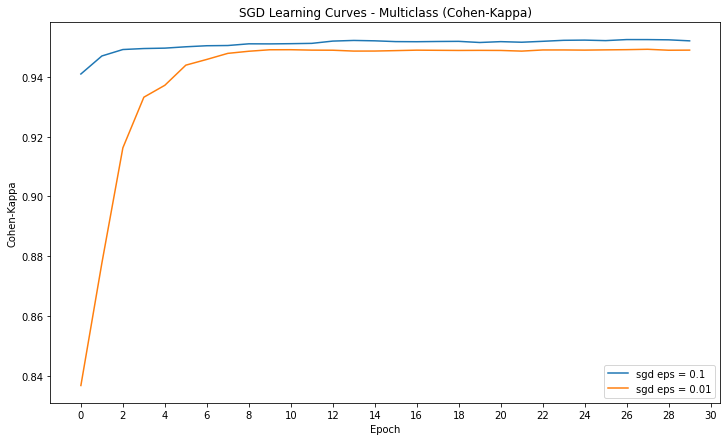

In [60]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Again, a learning rate of 0.1 seems to perform better than 0.01.

We briefly stop to make a comment on what we have observed. Were we to employ an early stopping point for our DNNs, a reasonable choice would have been to stop learning for a learning rate of 0.001 after 10-12 epochs, based on loss decrease flattening out. However, as we see from the accuracy and the Cohen-Kappa score, our model at that point is actually doing very badly and only really assigning everything to a single class, before improving after 15 or 16 epochs. Also, the learning rate of 0.1 performs so well, a 'good' stopping time would arguably be after a single epoch.

These observations are likely to be largely caused by the huge class imbalance in our dataset, and maybe somewhat inappropriate choice of loss function (though it was the best loss function that would think of currently, aside from creating a custom one which is outside of the scope of this report), but they do serve to point out why choosing an early stopping point for our epochs is not necessarily a clear problem, even if running for more epochs can lead to overfitting. Again, the best solution we can think for this problem is to define a better or custom loss function.

**Confusion Matrices**<br>
We now look more closely at the confusion matrices for the different learning rates for the categorical case here.

In [61]:
#setting random seed
tf.random.set_seed(rseed)

#predicting on test data for each epsilon
for i in range(len(epsilons)):
    #grab appropriate model
    model = locals()['sgd_categ_model_{}'.format(i+1)]
    #predict using model
    sgd_categ_pred = model.predict(X_test)
    #assign prediction to local variable
    locals()['sgd_categ_pred_{}'.format(i+1)] = sgd_categ_pred

Preview of categories

In [62]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

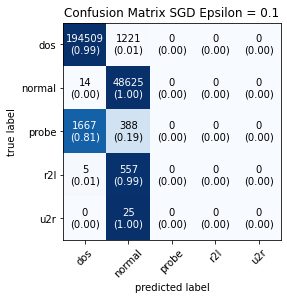

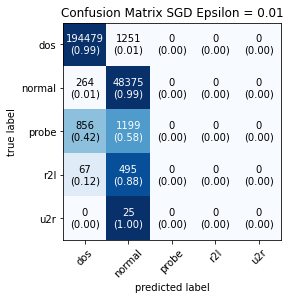

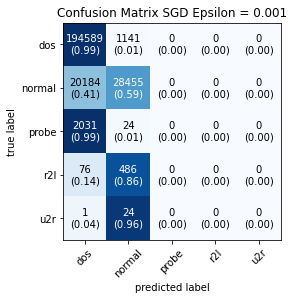

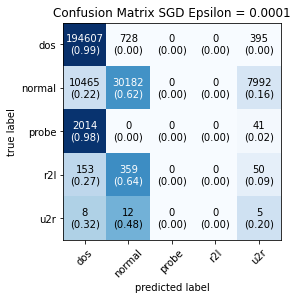

In [63]:
#plotting each confusion matrix
for i in range(len(epsilons)):
    #assign temp variable 
    sgd_categ_pred = locals()['sgd_categ_pred_{}'.format(i+1)]
    #plot confusion matrix, taking the class with the highest probability assigned as the model's prediction
    cmat_categ_sgd = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_categ_pred,axis=1))
    #assign confusion matrix to local variable
    locals()['cmat_categ_sgd_{}'.format(i+1)] = cmat_categ_sgd
   
    #plot
    plot_confusion_matrix(
        conf_mat = cmat_categ_sgd,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))

#delete temp to save memory    
del sgd_categ_pred

There are a few interesting things to observe here. Firstly, we see that although the learning rates of 0.1 and 0.01 seemed to perform well (in terms of accuracy), this is largely due to predicting dos and normal connections correctly. Notably, neither one of the two models assigns any of the observations to probe, r2l, or u2r. This may be fixed if we considered some threshold training where we assign observatins to certain categories if the softmax score is above a certain threshold, rather than assigning to whichever has the largest singular score, e.e.g if 'dos'=0.4 but 'probe'=0.2, assign to 'probe'. This could prevent generalisation of the model, however, so this method (as well as the additional steps and time that would be needed to implement it) seems somewhat less desirable as a solution.

Secondly, when we look at the lowest learning rate of 0.0001, we see that our model is actually able to categorise some u2r attacks (though whether it is actually detecting them is debatable, as it also categorises a significant percentage of normal, probe, and r2l connections as u2r), whereas none of the other learning rates were able to do this. This could just be thec ase of u2r falling in some region outside of the local minima that our model tends towards, and so predictions of u2r may just disappear with time. This would be something to further investigate by tuning parameters such as dropout rate, but we do not attempt this here.

Overall, there does seem to be overfitting done, and we suspect that a large part of that is due to the chosen loss function. But we do have that a learning rate of 0.1 performs seemingly the best out of the rest (including its failures in predicting classes other than 'normal' and 'dos') and so we will be comparing this model more closely to the best performing models seen for other optimisers.

## References for Section 3

- Keskar et al. 2017 https://arxiv.org/abs/1609.04836, ICLR 2017.